# Device hamiltonian and parameters
Ricordiamo l'hamiltoniana di un quantum annealer

$$ \mathcal{H}_{\text{ising}} = - \frac{A(s)}{2} \left( \sum_i \hat{\sigma}_x^{(i)} \right) + \frac{B(s)}{2} \left( \sum_i h_i \hat{\sigma}_z^{(i)} + \sum_{i>j} J_{i,j} \hat{\sigma}_z^{(i)} \hat{\sigma}_z^{(j)} \right) $$

dove $A(s), B(s)$ dipendono dal device, mentre $h_i, J_{i,j}$ sono definiti dall'utente.

In [310]:
%matplotlib inline

import pandas as pd
import numpy as np
import random
import pickle
from matplotlib import pyplot as plt

df = pd.read_excel('09-1216A-A_DW_2000Q_6_annealing_schedule.xls', sheet_name=1)
nominal_temp_ghz = 13.5 / 47.9924341590788

In [309]:
# df.head()

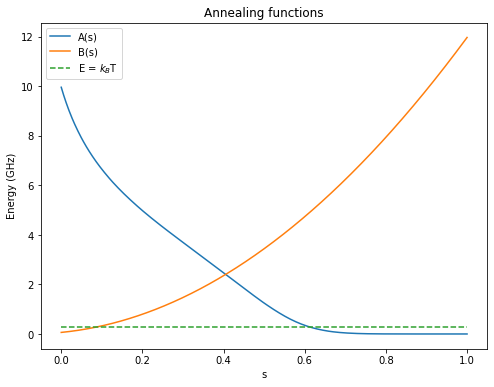

In [311]:
plt.figure(figsize=(8, 6))
plt.plot(df['s'], df['A(s) (GHz)'], label='A(s)')
plt.plot(df['s'], df['B(s) (GHz)'], label='B(s)')
plt.plot(np.linspace(0,1), nominal_temp_ghz * np.ones(50), linestyle='--', label='E = $k_B$T')

plt.title('Annealing functions')
plt.xlabel('s')
plt.ylabel('Energy (GHz)')
plt.legend()
plt.show()

# Single qubit temperature measurements
Riducendosi a considerare un singolo spin, abbiamo libertà di scegliere *h* e il parametro di annealing *s(t)*.

$$ \quad \forall i,j \quad J_{i,j}=0 $$

$$ \mathcal{H}_{\text{single qubit}} = - \frac{A(s)}{2} \hat{\sigma}_x + \frac{B(s)}{2} h \hat{\sigma}_z $$

Salto minimo di energia per h=0.5: 2.110 GHz
Salto minimo di energia per h=0.01: 0.070 GHz
Energia termica nominale: 0.281 GHz


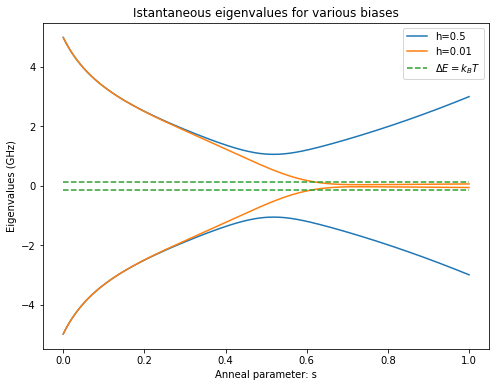

In [329]:
# plot hamiltonian istantanous eigenvalues
biases = [0.5, 0.01]
colors = ['C0', 'C1']

sigma_x = np.array([[0, 1], [1, 0]])
sigma_z = np.diag([1, -1])

plt.figure(figsize=(8, 6))
plt.title(f'Istantaneous eigenvalues for various biases')

for h, c in zip(biases, colors):
    # H è una lista di matrici, eigenvals è una lista di coppie di autovalori
    H = [a / 2 * sigma_x + b / 2 * h * sigma_z for a, b in zip(df['A(s) (GHz)'], df['B(s) (GHz)'])]
    eigenvals = [np.linalg.eigvalsh(hamilt) for hamilt in H]

    anneal_parameter = np.linspace(0, 1, len(eigenvals))
    negative_eigenvals, positive_eigenvals = np.array(eigenvals).T
    print(f'Salto minimo di energia per h={h}: {np.min(positive_eigenvals - negative_eigenvals):.3f} GHz')

    # faccio la figura
    plt.plot(anneal_parameter, negative_eigenvals, c=c, label=f'h={h}')
    plt.plot(anneal_parameter, positive_eigenvals, c=c)

print(f'Energia termica nominale: {nominal_temp_ghz:.3f} GHz')
plt.plot(np.linspace(0, 1), nominal_temp_ghz * np.ones(50) / 2, c='C2', linestyle='--', label='$\Delta E=k_B T$')
plt.plot(np.linspace(0, 1), - nominal_temp_ghz * np.ones(50) / 2, c='C2', linestyle='--')

plt.xlabel('Anneal parameter: s')
plt.ylabel('Eigenvalues (GHz)')
plt.legend()
plt.show()

In [335]:
# cerco quali device sono disponibili al momento
from dwave.cloud import Client

with Client.from_config() as client:
    for solver in client.get_solvers():
        print(solver.id)

DW_2000Q_6
hybrid_binary_quadratic_model_version2
hybrid_discrete_quadratic_model_version1
Advantage_system1.1


In [337]:
# scelgo il device e mi assicuro di poterci comunicare, stampo a schermo alcune caratteristiche
from dwave.system import DWaveSampler
import dwave.inspector

sampler = DWaveSampler(solver='DW_2000Q_6')

print(f'Maximum anneal-schedule points: {sampler.properties["max_anneal_schedule_points"]}')
print(f'Annealing time range: {sampler.properties["annealing_time_range"]} \u03BCs')
print(f'Maximum slope allowed on this solver is {1.0/sampler.properties["annealing_time_range"][0]}')

# sampler.parameters

Maximum anneal-schedule points: 12
Annealing time range: [1, 2000] μs
Maximum slope allowed on this solver is 1.0


## Classical approach: trivial reverse annealing

Come prima cosa, inizializzo il mio stato direttamente in un autostato di $\hat \sigma_z$ utilizzando il reverse annealing. Inizializzo lo stato nel primo eccitato e non modificare il parametro di annealing. Aspetto il tempo massimo compatibile con la macchina e misuro lo stato lungo $\hat \sigma_z$.

In [330]:
# parametri
annealing_time = 2000
h1 = 0.05
# per h = 0.028, il gap di l'energia lungo z fra il ground e il primo ecc dovrebbe essere pari all'energia termica

trivial_reverse_schedule = [[0.0, 1.0], [annealing_time, 1.0]]
linear_offsets = {active_node: h1 * random.choice([-1, 1]) for active_node in sampler.nodelist}
initial_state = {active_node: np.sign(linear_offsets[active_node]) for active_node in linear_offsets}

In [338]:
# RUN 'thermal' evolution of excited sigma_z eigenstate

sampler.validate_anneal_schedule(trivial_reverse_schedule)
# sampleset = sampler.sample_ising(linear_offsets, {}, num_reads=10, auto_scale=False, anneal_schedule=trivial_reverse_schedule, initial_state=initial_state, label=f'Trivial reverse annealing test h={h}')

# save data to file
# pickle.dump((linear_offsets, sampleset), open("trivial_reverse_annealing.pickle", "wb"))

In [ ]:
linear_offsets, sampleset = pickle.load(open("trivial_reverse_annealing.pickle", "rb"))
print(sampleset)

In [9]:
# unique_results = [len(np.unique(sampleset.record[i].sample)) for i in range(len(sampleset))]
# print(f'Nelle mie {len(sampleset)} run, ho ottenuto {unique_results} valori unici\n')

# print_risultati(sampleset, linear_offsets, h1)
# sampleset.to_pandas_dataframe()

Anche in questo caso mi aspetto che la dinamica di evoluzione (classica) si troppo lenta rispetto a $t_f$ e di non riuscire a vedere la termalizzazione.

## Boltzmann distribution

Naively, one might expect the final distribution at the end of the anneal to be a classical Boltzmann distribution
for the problem Hamiltonian H at the operating temperature of the device, specifically,

$$\rho \sim \exp (- \beta B(1) h \hat{\sigma}_z / 2), \qquad \text{where} \quad \beta = 1/k_B T,$$

with T the operating temperature of the annealer (on the order of $10-20mK$). But it has long been known that is not the case.

La dinamica degli stati si ferma quando il tempo scala di evoluzione, governato da A(s) diventa maggiore di $t_f$. L'uguaglianza dei tempi è detta **freezout point**.

La distribuzione finale degli stati sarà simile a $$\rho \sim \exp (- \beta B(s^*) h \hat{\sigma}_z / 2), $$ dove $s^*$ è il freezout point del sistema.

La distribuzione di popolazione che mi aspetto è

$$P_↑/(1-P_↑)=\exp(-\delta E / k_B T) \qquad \text{con} \quad \delta E = h \times B(s^*)/2 $$

### Find T assuming s*= 0.719

###### Using just a single spin

In [14]:
# single spin example
h = {4: 0.01}
J = {}

# RUN samples
# sampleset = sampler.sample_ising(h, J, num_reads=20, auto_scale=False, label='Autoscale False')

In [25]:
# print and view results
print(sampleset)
# dwave.inspector.show(sampleset)

   0 energy num_oc.
0 -1  -0.01       9
1 +1   0.01      11
['SPIN', 2 rows, 20 samples, 1 variables]


In [101]:
# save data to file
pickle.dump(sampleset, open("boltzmann/prova.pickle", "wb"))

In [134]:
# load data from pickle example
loaded_data = pickle.load(open("boltzmann/prova.pickle", "rb"))
print(loaded_data)

   0 energy num_oc.
0 -1  -0.01       9
1 +1   0.01      11
['SPIN', 2 rows, 20 samples, 1 variables]


###### Using all spins indipendently

In [271]:
N = 20

In [183]:
# RUN different energy gap samples for all active spins in machine
biases = np.linspace(-0.3, 0.3, N)

for i, h in enumerate(biases):
    linear_offsets = {active_node: h * random.choice([-1, 1]) for active_node in sampler.nodelist}
    # sampleset = sampler.sample_ising(linear_offsets, {}, num_reads = 10, auto_scale=False, label=f'Boltzmann h={h}')
    
    # save data to file
    # pickle.dump((h, sampleset), open(f"boltzmann/{i}.pickle", "wb"))

In [249]:
def spin_up_pop(record, h):
    # calcoliamo la percentuale di popolamento dello stato con spin positivo lungo z
    if h == 0:
        return 0.5
    num_spins = len(record['sample'][0])
    all_spin_up_energy = - h * num_spins
    ensamble_energy = np.sum(record.num_occurrences * (record.energy - all_spin_up_energy) / record.num_occurrences.sum())
    
    n_spin_down = ensamble_energy / 2 / h / num_spins
    n_std = 1 / np.sqrt(4 * num_spins * record.num_occurrences.sum())
    
    return 1 - n_spin_down, n_std

In [250]:
# load data from file
n_spin_up = []
dn_spin_up = []
biases = []

for i in range(N):
    h, loaded_sampleset = pickle.load(open(f"boltzmann/{i}.pickle", "rb"))
    spin_up, dspin_up = spin_up_pop(loaded_sampleset.record, h)
    
    biases.append(h)
    n_spin_up.append(spin_up)
    dn_spin_up.append(dspin_up)
    
biases = np.array(biases)
n_spin_up = np.array(n_spin_up)
dn_spin_up = np.array(dn_spin_up)

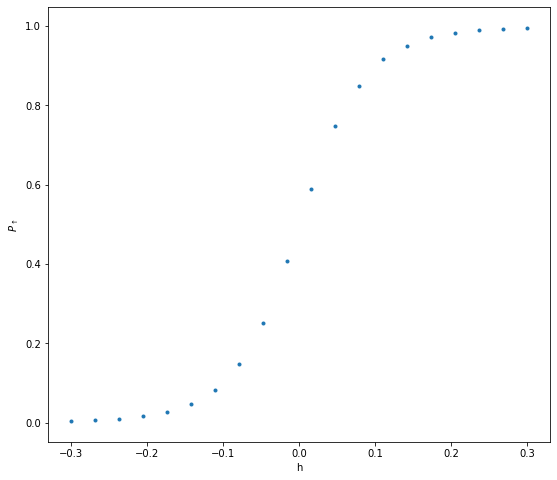

In [251]:
# grafico popolaz ground state vs h
plt.figure(figsize=(9,8))
plt.errorbar(biases, n_spin_up, dn_spin_up, marker='.', linestyle='')
plt.xlabel('h')
plt.ylabel(r'$P_\uparrow$')
plt.show()

In [267]:
from scipy.optimize import curve_fit

def temperature_fit_function(x, T):
    return 1 / (1 + np.exp(- x / 2 / T))

In [327]:
# definisco s star e trovo il valore corrispondente per B
s_star = 0.719
closest_s = df.iloc[(df['s'] - s_star).abs().argsort()[0]]

6.543006

$$ \frac{P_\uparrow}{1-P_\uparrow}=\exp \left( \frac{-B(s^*)h}{2 k_B T} \right) $$

<!-- $$ P_\uparrow = \frac{\exp \left( \frac{-B(s^*)h}{2 k_B T} \right)}{1 + \exp \left( \frac{-B(s^*)h}{2 k_B T} \right)} $$ -->

$$ P_\uparrow = \left[ 1 + \exp \left( \frac{B(s^*)h}{2 k_B T} \right) \right] ^{-1} $$

In [300]:
# faccio il fit della curva per trovare la temperatura
popt, pcov = curve_fit(temperature_fit_function, closest_s['B(s) (GHz)'] * biases, n_spin_up, sigma = dn_spin_up, absolute_sigma=True)

# compute the mean and the chi^2/dof
z = (n_spin_up - temperature_fit_function(closest_s['B(s) (GHz)'] * biases, popt[0])) / dn_spin_up
chi2 = np.sum(z ** 2)
chi2dof = chi2 / (N - 1)
sigma = np.sqrt(2. / (N - 1))
nsig = (chi2dof - 1) / sigma
    
ghz_to_mk = 0.0479924341590788 * 1000

print('La temperatura di un singolo qubit risulta: {0:.4f} +/- {1:.4f} GHz'.format( popt[0], np.sqrt(pcov[0][0]) ))
print('Equivalente a {0:.2f} +/- {1:.2f} mK'.format( popt[0] * ghz_to_mk, np.sqrt(pcov[0][0]) * ghz_to_mk))

chi2dof

La temperatura di un singolo qubit risulta: 0.2717 +/- 0.0012 GHz
Equivalente a 13.04 +/- 0.06 mK


4.898428529295436

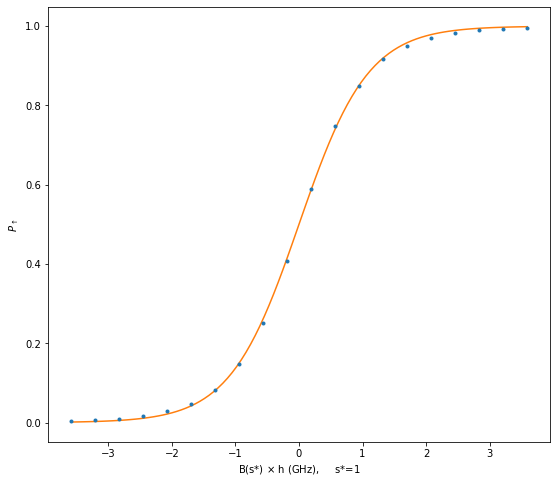

In [303]:
# rifaccio il grafico mettendo B sull'asse delle ascisse
xx = np.linspace(min(closest_s['B(s) (GHz)'] * biases), max(closest_s['B(s) (GHz)'] * biases), 100)

plt.figure(figsize=(9,8))
plt.errorbar(closest_s['B(s) (GHz)'] * biases, 1 - n_ground, dn_ground, marker='.', linestyle='')
plt.plot(xx, temperature_fit_function(xx, popt))
plt.xlabel(r'B(s*) $\times$ h (GHz), $\quad$ s*=' + str(s_star))
plt.ylabel(r'$P_\uparrow$')
plt.show()

### Find s*

## Initial quench and pause

L'idea è che facendo un veloce quench del qubit, questo vada più spesso nello stato ad alta energia perché guidato dall'*energia cinetica* dell'annealing, rispetto alla distribuzione che avrei andando lentamente (influenzata solo dal bagno termico).

Aspettando sufficiente tempo, lo stato evolve verso una situazione di equilibrio e campionando questa evoluzione riesco a descrivere il processo di termalizzazione.

In [102]:
# parametri
t_quench = 2.0
t_f = 20.0
h0 = 0.0001
# per h = 0.025, l'energia lungo z dovrebbe essere pari all'energia termica

quench_schedule = [[0.0, 0.0], [t_quench, 1.0], [t_f, 1.0]]
linear_offsets = {active_node: h0 if active_node % 2 == 0 else -h0 for active_node in sampler.nodelist}

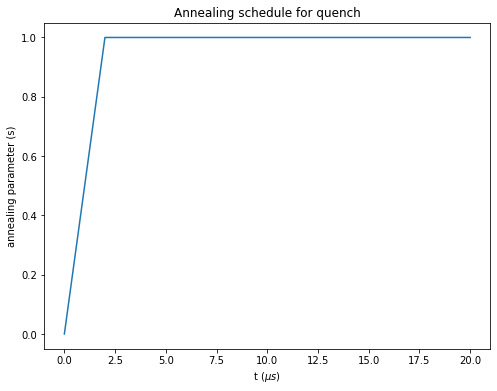

In [110]:
# mostriamo l'annealing schedule
plt.figure(figsize=(8, 6))
plt.plot(*np.array(quench_schedule).T)

plt.title('Annealing schedule for quench')
plt.xlabel('t ($\mu s$)')
plt.ylabel('annealing parameter (s)')
plt.show()

Tuttavia dopo il quench, la dinamica del qubit, governata da $A(s)$, evolve con tempi scala $t>>t_f=200\mu s$

Di conseguenza mi aspetto di non riuscire a vedere la termalizzazione

In [82]:
# campioniamo il sistema dopo il quench
sampler.validate_anneal_schedule(quench_schedule)
sampleset0 = sampler.sample_ising(linear_offsets, {}, num_reads=10, anneal_schedule=quench_schedule, label=f'Quench test h={h}')

print(sampleset0)

   0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 ... 2047 energy num_oc.
0 -1 +1 -1 +1 -1 +1 -1 +1 -1 +1 -1 +1 -1 +1 -1 +1 -1 +1 ...   +1 -2.041      10
['SPIN', 1 rows, 10 samples, 2041 variables]


In [192]:
def print_risultati(sampleset, linear_offsets, h):
    # quanti risultati diversi abbiamo trovato
    print(f'Ho ottenuto {len(sampleset.record)} risultato(i) diverso(i).')
    
    # per ognuno di questi risultati ci facciamo dire se è il minimo globale o no
    for ii in range(len(sampleset.record)):
        results = sampleset.record[ii].sample
        biases = np.array(list(linear_offsets.values()))
        if np.all(np.sign(results) != np.sign(biases)):
            print(f"Tutti gli spin sono nel minimo dell'energia, per h={h}.")
        elif np.all(np.sign(results) == np.sign(biases)):
            print(f"Tutti gli spin sono nel massimo dell'energia, per h={h}.")
        else:
            print("Ho almeno uno spin NON nel minimo/massimo.")

In [7]:
# print_risultati(sampleset0, linear_offsets, h0)

# Entanglement creation